In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from collections import Counter
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, log_loss, roc_auc_score
print("******************All files imported*****************")

******************All files imported*****************


In [39]:
#First I will do preprocessing on dataset 
df = pd.read_csv('Dataset.csv')
print("Dataset shape: ",df.shape[0]," rows and ", df.shape[1]," columns")
print("\nDataset Overview\n")
print(df.head())
print("Column Names: ")
print(df.columns.tolist())
print("Dataset Info \n")
print(df.info())

                 

Dataset shape:  513  rows and  14  columns

Dataset Overview

             Timestamp                             Gmail  Age  Country  \
0  11/13/2025 11:41:17  ogunseijuoluwafolakemi@gmail.com   23  Nigeria   
1  11/13/2025 11:53:13        shubhamkumarhrt1@gmail.com   20    india   
2  11/13/2025 11:58:01    adithyavinodnair2004@gmail.com   21    India   
3  11/13/2025 11:59:31         prachidhiman362@gmail.com   19    India   
4  11/13/2025 12:45:00                sner9458@gmail.com   22   India    

   Gender   Income Level  ($)   Frequency of Online Shopping    \
0  Female             < $5000                           Monthy   
1    Male        $5000-$10000                           Monthy   
2    Male             < $5000                           Monthy   
3  Female             < $5000                           Rarely   
4  Female        $5000-$10000                           Rarely   

    Favorite Product Categories     Average Spending per Order  ($)  \
0        Electronics, Acc

In [40]:
#Now lets clean it 
#There are spaces in teh column names so lets remove them 
df.columns= df.columns.str.strip()


#Columns like timestamp and gmail are not useful for prediction so lets drop them
df = df.drop(['Timestamp', 'Gmail'], axis=1)
print("Remaining colums: ",df.shape[1])
print(df.columns.tolist())


Remaining colums:  12
['Age', 'Country', 'Gender', 'Income Level  ($)', 'Frequency of Online Shopping', 'Favorite Product Categories', 'Average Spending per Order  ($)', 'Payment Method Preference', 'Browsing Time on E-commerce Sites (per day)', 'Purchase Decision Influencer', 'Customer Type', 'Monthly Spending ($)']


Lets Make all currencies in correct format

In [41]:
def clean_currency(x):
    if pd.isna(x):
        return 0.0
    
    x_str = str(x).lower().replace(',', '').strip()
    
    if 'k' in x_str:
        x_str = x_str.replace('k', '')
        multiplier = 1000
    else:
        multiplier = 1
    
    numbers = re.findall(r"\d+\.?\d*", x_str)
    
    if numbers:
        return float(numbers[-1]) * multiplier
    
    return 0.0

#Because there are the columns that are in currenices 
df['Monthly Spending ($)'] = df['Monthly Spending ($)'].apply(clean_currency)
df['Average Spending per Order  ($)'] = df['Average Spending per Order  ($)'].apply(clean_currency)

#Lets see the change 
print("*******************After Cleaning Currency Columns*****************\n")
print(df[['Monthly Spending ($)', 'Average Spending per Order  ($)']].head())

*******************After Cleaning Currency Columns*****************

   Monthly Spending ($)  Average Spending per Order  ($)
0                 20.00                             20.0
1              55000.00                             56.0
2                 25.00                             20.0
3                 33.81                             50.0
4                 45.00                             35.0


Now Country column and gender column have some inconsistencies like India in country col is written in multiple forms so lets correct them 

In [42]:
df['Country'] = df['Country'].str.lower().str.strip()
df['Country'] = df['Country'].replace({
    'indiia': 'india',
    'india ': 'india',
    'indian ': 'india',
    'indian': 'india'
})

df['Gender'] = df['Gender'].str.strip()
df['Gender'] = df['Gender'].replace({'Prefer not to say': 'Other'})

print(f"Countries:  {df['Country'].unique()}")
print(f"\nGenders: {df['Gender'].unique()}")

Countries:  ['nigeria' 'india' 'hungary' 'italy' 'czechia' 'uk' 'germany' 'lithuania'
 'france' 'portugal' 'czech republic' 'ny' 'china' 'usa' 'lt' 'canada'
 'taiwan' 'tn' 'glasgow' 'netherlands' 'kurdistan' 'malaysia' 'egypt'
 'spain' 'australia' 'ireland']

Genders: ['Female' 'Male' 'Other']


Now Encoding part because columns such as income level which are <5000$ and two diffent types adn othet ciolumns also need encoding to make iut model friendly 

In [43]:
#make three categoes in numbers (0,1,2)
income_map = {'< $5000': 0, '$5000-$10000': 1, '> $10,000': 2}
df['Income Level  ($)'] = df['Income Level  ($)'].map(income_map).fillna(0)

#similar hgere
freq_map = {'Rarely': 0, 'Monthy': 1, 'Weekly': 2, 'Daily': 3}
df['Frequency of Online Shopping'] = df['Frequency of Online Shopping'].map(freq_map).fillna(1)

#and here also 
time_map = {'< 1 hrs': 0, '1-2 hrs': 1, '2-4 hrs': 2, '> 4 hrs': 3, '>4 hrs': 3}
df['Browsing Time on E-commerce Sites (per day)'] = df['Browsing Time on E-commerce Sites (per day)'].map(time_map).fillna(1)

print(f"\n Encoded Features Sample:")
print(df[['Income Level  ($)', 'Frequency of Online Shopping', 'Browsing Time on E-commerce Sites (per day)']].head())


 Encoded Features Sample:
   Income Level  ($)  Frequency of Online Shopping  \
0                  0                             1   
1                  1                             1   
2                  0                             1   
3                  0                             0   
4                  1                             0   

   Browsing Time on E-commerce Sites (per day)  
0                                            1  
1                                            2  
2                                            1  
3                                            2  
4                                            0  


Now lets add some more columns in the datset based on the other columns which will be useful for the models 

In [44]:
#Category count columns:  Counts how many product categories a customer is interested in (splits by comma)
# Customers interested in more categories might spend more or shop more frequently
df['Category_Count'] = df['Favorite Product Categories'].apply(lambda x: len(str(x).split(',')))

#Spending ratio: Calculates how many orders a customer places per month
#Indicates shopping frequency pattern (frequent small orders vs rare large orders)
df['Spending_Ratio'] = df['Monthly Spending ($)'] / (df['Average Spending per Order  ($)'] + 1)

#Spending per browsing hour : Measures spending efficiency per browsing time
#Identifies decisive buyers vs browsers who don't convert to purchases
df['Spending_per_BrowsingHour'] = df['Monthly Spending ($)'] / (df['Browsing Time on E-commerce Sites (per day)'] + 1)

#Income frequency interaction: Combines income level with shopping frequency
#Captures the relationship between purchasing power and shopping habits
df['Income_Frequency_Interaction'] = df['Income Level  ($)'] * df['Frequency of Online Shopping']


#High value indicator :Creates a binary flag (0 or 1) for high-value customers
#Directly identifies premium customers who spend a lot and place high-value orders

df['High_Value_Indicator'] = ((df['Monthly Spending ($)'] > df['Monthly Spending ($)'].median()) & 
                               (df['Average Spending per Order  ($)'] > df['Average Spending per Order  ($)'].median())).astype(int)


#Now there is no use of favourite product categories
df = df.drop(columns=['Favorite Product Categories'])

print("*******************New features created:*************")
print("   Category_Count")
print("   Spending_Ratio")
print("   Spending_per_BrowsingHour")
print("   Income_Frequency_Interaction")
print("   High_Value_Indicator")

print("\nNew features values: ")
print(df[['Category_Count','Spending_Ratio', 'Income_Frequency_Interaction', 'Spending_per_BrowsingHour', 'High_Value_Indicator']].head())


*******************New features created:*************
   Category_Count
   Spending_Ratio
   Spending_per_BrowsingHour
   Income_Frequency_Interaction
   High_Value_Indicator

New features values: 
   Category_Count  Spending_Ratio  Income_Frequency_Interaction  \
0               2        0.952381                             0   
1               1      964.912281                             1   
2               2        1.190476                             0   
3               1        0.662941                             0   
4               2        1.250000                             0   

   Spending_per_BrowsingHour  High_Value_Indicator  
0                  10.000000                     0  
1               18333.333333                     0  
2                  12.500000                     0  
3                  11.270000                     0  
4                  45.000000                     0  


Now lets do One-hot encoding tfor categorical data


In [45]:
categorical_cols = ['Country', 'Gender', 'Payment Method Preference', 'Purchase Decision Influencer']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("Total features after encoding : ",df.shape[1])
print(df.columns.tolist())


Total features after encoding :  48
['Age', 'Income Level  ($)', 'Frequency of Online Shopping', 'Average Spending per Order  ($)', 'Browsing Time on E-commerce Sites (per day)', 'Customer Type', 'Monthly Spending ($)', 'Category_Count', 'Spending_Ratio', 'Spending_per_BrowsingHour', 'Income_Frequency_Interaction', 'High_Value_Indicator', 'Country_canada', 'Country_china', 'Country_czech republic', 'Country_czechia', 'Country_egypt', 'Country_france', 'Country_germany', 'Country_glasgow', 'Country_hungary', 'Country_india', 'Country_ireland', 'Country_italy', 'Country_kurdistan', 'Country_lithuania', 'Country_lt', 'Country_malaysia', 'Country_netherlands', 'Country_nigeria', 'Country_ny', 'Country_portugal', 'Country_spain', 'Country_taiwan', 'Country_tn', 'Country_uk', 'Country_usa', 'Gender_Male', 'Gender_Other', 'Payment Method Preference_Credit Card', 'Payment Method Preference_Debit Card', 'Payment Method Preference_Net Banking', 'Payment Method Preference_UPI', 'Payment Method Pr

Label encoding on target variable ( Customer type)


In [ ]:
#high spender-0, Low spender-1, Medium spendor-2
le = LabelEncoder()
df['Customer Type'] = le.fit_transform(df['Customer Type'])
print("\n Target Classes:", le.classes_)
print("\n*******Class Distribution********")
class_counts = df['Customer Type'].value_counts().sort_index()
for idx, count in class_counts.items():
    class_name = le.classes_[idx]
    print(f"  {class_name}: {count} samples ({count/len(df)*100:.1f}%)")



 Target Classes: ['High Spender' 'Low Spender' 'Medium  Spender']

*******Class Distribution********
  High Spender: 153 samples (29.8%)
  Low Spender: 153 samples (29.8%)
  Medium  Spender: 207 samples (40.4%)


Now lets do EDA( lets visualise our data with charts )


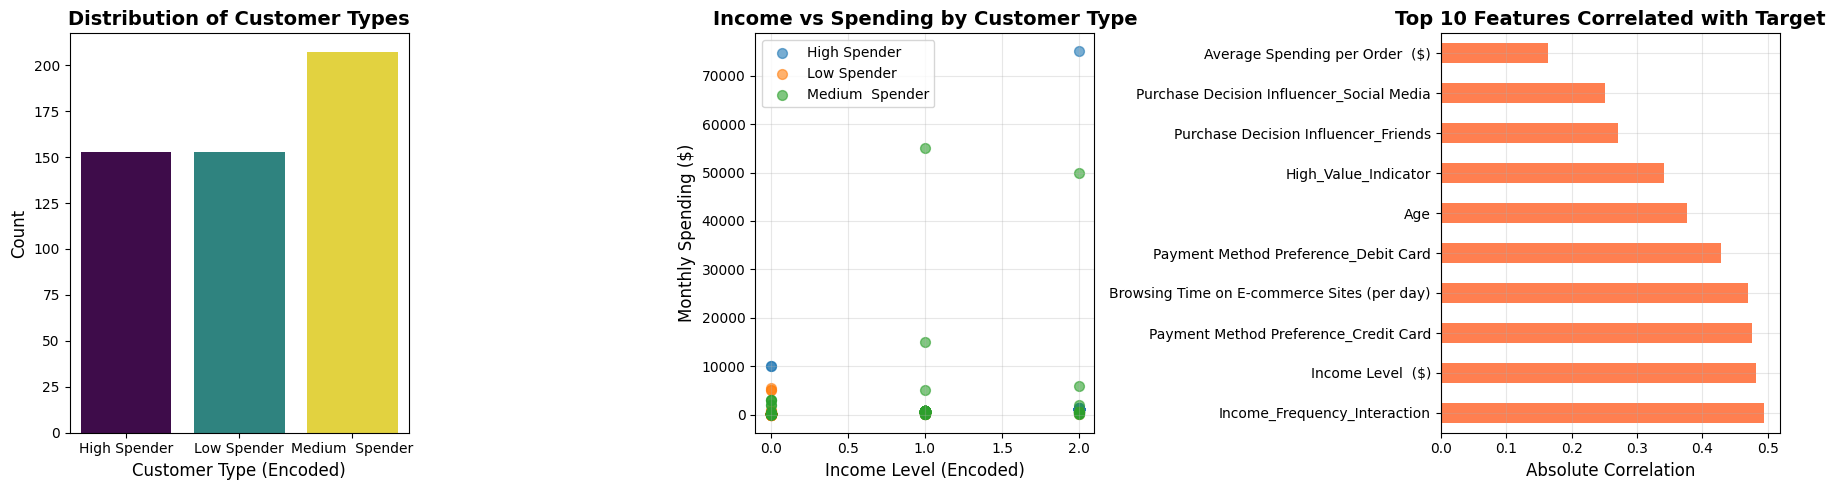


✓ EDA visualizations displayed successfully!


In [47]:
# EDA Visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Distribution of Customer Types
sns.countplot(x=df['Customer Type'], hue=df['Customer Type'], palette='viridis', legend=False, ax=axes[0])
axes[0].set_title('Distribution of Customer Types', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Customer Type (Encoded)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(le.classes_, rotation=0)

# Plot 2: Income vs Spending by Customer Type
for idx, class_name in enumerate(le.classes_):
    mask = df['Customer Type'] == idx
    axes[1].scatter(df[mask]['Income Level  ($)'], df[mask]['Monthly Spending ($)'], 
                   label=class_name, alpha=0.6, s=50)
axes[1].set_title('Income vs Spending by Customer Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Income Level (Encoded)', fontsize=12)
axes[1].set_ylabel('Monthly Spending ($)', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

# Plot 3: Top Features Correlated with Target
correlation_with_target = df.corr()['Customer Type'].abs().sort_values(ascending=False)[1:11]
correlation_with_target.plot(kind='barh', color='coral', ax=axes[2])
axes[2].set_title('Top 10 Features Correlated with Target', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Absolute Correlation', fontsize=12)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ EDA visualizations displayed successfully!")

Now lets prepare training and test data

In [51]:
X = df.drop(columns=['Customer Type'])
y = df['Customer Type']

print(f"\n Features: {X.shape[1]} columns, {X.shape[0]} samples")
print(f" Class distribution:",y.value_counts().to_dict())

# Feature scaling for better model performance
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42, stratify=y)

print(f"\n Training set: {X_train.shape[0]} samples")
print(f" Test set: {X_test.shape[0]} samples")



 Features: 47 columns, 513 samples
 Class distribution: {2: 207, 1: 153, 0: 153}

 Training set: 410 samples
 Test set: 103 samples


Now lets apply logistic regression 

In [53]:
#Model 1: Logistic Regression
model1= LogisticRegression(
    C=1.0,
    max_iter=2000,
    class_weight='balanced',
    solver='lbfgs',
    random_state=42,
    n_jobs=-1
)

model1.fit(X_train, y_train)

train_pred= model1.predict(X_train)
test_pred=model1.predict(X_test)


#Cross validation score 
cross= cross_val_score(model1, X_train, y_train, cv=3, scoring='accuracy')

print("\n Performance Metrics:")
print("  Cross-Validation Accuracy: ", round(cross.mean()*100, 2), "%")
print("  Training Accuracy:         ", round(accuracy_score(y_train, train_pred)*100, 2), "%")
print("  Test Accuracy:             ", round(accuracy_score(y_test, test_pred)*100, 2), "%")
print("  Precision:                 ", round(precision_score(y_test, test_pred, average='weighted')*100, 2), "%")
print("  Recall:                    ", round(recall_score(y_test, test_pred, average='weighted')*100, 2), "%")
print("  F1-Score:                  ", round(f1_score(y_test, test_pred, average='weighted')*100, 2), "%")



 Performance Metrics:
  Cross-Validation Accuracy:  90.49 %
  Training Accuracy:          95.37 %
  Test Accuracy:              91.26 %
  Precision:                  91.38 %
  Recall:                     91.26 %
  F1-Score:                   91.31 %


In [54]:
#Classification Repoort 
print(classification_report(y_test, test_pred, target_names=le.classes_, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
print("\n Confusion Matrix:")
print(cm)


                 precision    recall  f1-score   support

   High Spender      1.000     0.968     0.984        31
    Low Spender      0.871     0.871     0.871        31
Medium  Spender      0.881     0.902     0.892        41

       accuracy                          0.913       103
      macro avg      0.917     0.914     0.915       103
   weighted avg      0.914     0.913     0.913       103


 Confusion Matrix:
[[30  0  1]
 [ 0 27  4]
 [ 0  4 37]]


Confusion matrix visualization


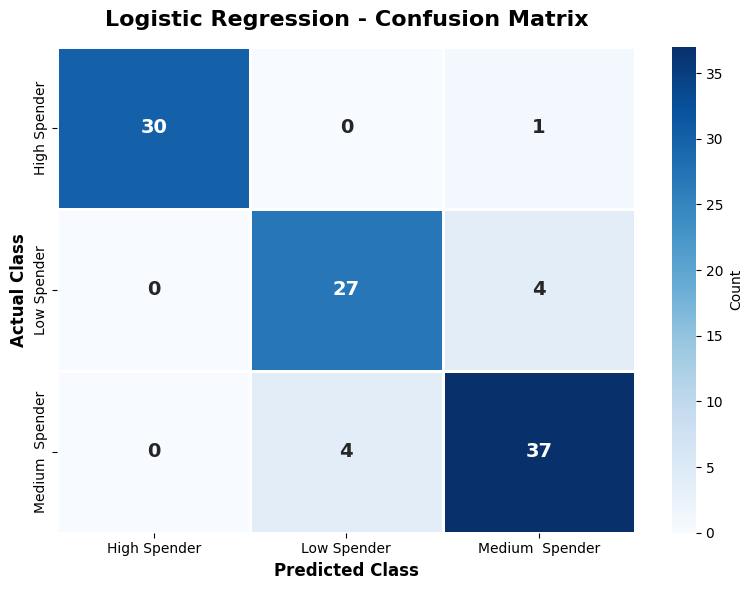

In [55]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_,
            linewidths=2, linecolor='white', cbar_kws={'label': 'Count'},
            annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Logistic Regression - Confusion Matrix', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Actual Class', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()



Next model Gradient Boosting


In [59]:
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    subsample=0.9,
    random_state=42
)


gb_model.fit(X_train, y_train)

# Predictions
gb_train_preds = gb_model.predict(X_train)
gb_test_preds = gb_model.predict(X_test)


# Cross-validation
gb_cv_scores = cross_val_score(gb_model, X_train, y_train, cv=3, scoring='accuracy')

print(f"\n Performance Metrics:")
print(f"  Cross-Validation Accuracy:  {gb_cv_scores.mean()*100:.2f}%")
print(f"  Training Accuracy:          {accuracy_score(y_train, gb_train_preds)*100:.2f}%")
print(f"  Test Accuracy:              {accuracy_score(y_test, gb_test_preds)*100:.2f}%")
print(f"  Precision:                  {precision_score(y_test, gb_test_preds, average='weighted')*100:.2f}%")
print(f"  Recall:                     {recall_score(y_test, gb_test_preds, average='weighted')*100:.2f}%")
print(f"  F1-Score:                   {f1_score(y_test, gb_test_preds, average='weighted')*100:.2f}%")


print("\n                   Detailed Classification Report:")

print(classification_report(y_test, gb_test_preds, target_names=le.classes_, digits=3))

# Confusion Matrix
cm_gb = confusion_matrix(y_test, gb_test_preds)
print("\nConfusion Matrix:")
print(cm_gb)


 Performance Metrics:
  Cross-Validation Accuracy:  88.05%
  Training Accuracy:          100.00%
  Test Accuracy:              90.29%
  Precision:                  90.44%
  Recall:                     90.29%
  F1-Score:                   90.35%

                   Detailed Classification Report:
                 precision    recall  f1-score   support

   High Spender      1.000     0.968     0.984        31
    Low Spender      0.844     0.871     0.857        31
Medium  Spender      0.878     0.878     0.878        41

       accuracy                          0.903       103
      macro avg      0.907     0.906     0.906       103
   weighted avg      0.904     0.903     0.904       103


Confusion Matrix:
[[30  0  1]
 [ 0 27  4]
 [ 0  5 36]]


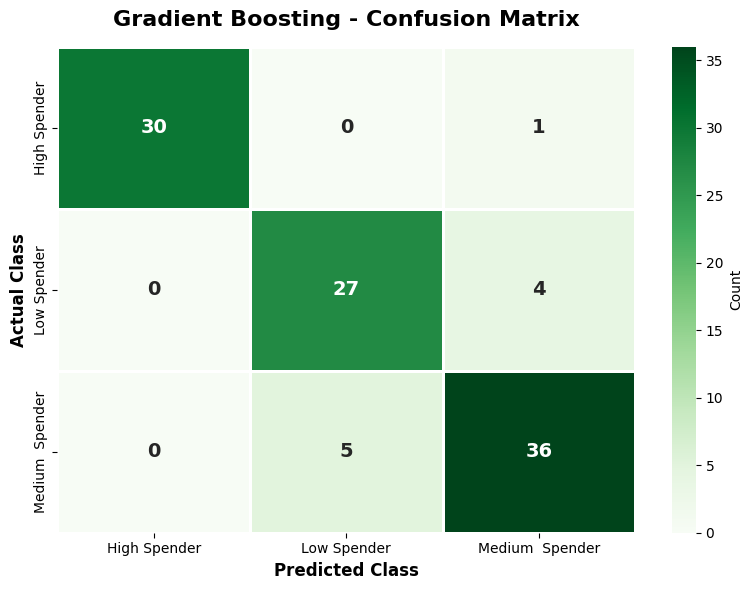

In [60]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le.classes_, yticklabels=le.classes_,
            linewidths=2, linecolor='white', cbar_kws={'label': 'Count'},
            annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Gradient Boosting - Confusion Matrix', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Actual Class', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


Random Forest - Model 3


In [61]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)


rf_model.fit(X_train, y_train)


# Predictions
rf_train_preds = rf_model.predict(X_train)
rf_test_preds = rf_model.predict(X_test)


# Cross-validation
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=3, scoring='accuracy')

print(f"\n Performance Metrics:")
print(f"  Cross-Validation Accuracy:  {rf_cv_scores.mean()*100:.2f}%")
print(f"  Training Accuracy:          {accuracy_score(y_train, rf_train_preds)*100:.2f}%")
print(f"  Test Accuracy:              {accuracy_score(y_test, rf_test_preds)*100:.2f}%")
print(f"  Precision:                  {precision_score(y_test, rf_test_preds, average='weighted')*100:.2f}%")
print(f"  Recall:                     {recall_score(y_test, rf_test_preds, average='weighted')*100:.2f}%")
print(f"  F1-Score:                   {f1_score(y_test, rf_test_preds, average='weighted')*100:.2f}%")

print("\n               Detailed Classification Report:")

print(classification_report(y_test, rf_test_preds, target_names=le.classes_, digits=3))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_test_preds)
print("\n Confusion Matrix:")
print(cm_rf)


 Performance Metrics:
  Cross-Validation Accuracy:  88.54%
  Training Accuracy:          100.00%
  Test Accuracy:              88.35%
  Precision:                  89.01%
  Recall:                     88.35%
  F1-Score:                   88.44%

               Detailed Classification Report:
                 precision    recall  f1-score   support

   High Spender      1.000     0.968     0.984        31
    Low Spender      0.778     0.903     0.836        31
Medium  Spender      0.892     0.805     0.846        41

       accuracy                          0.883       103
      macro avg      0.890     0.892     0.889       103
   weighted avg      0.890     0.883     0.884       103


 Confusion Matrix:
[[30  0  1]
 [ 0 28  3]
 [ 0  8 33]]


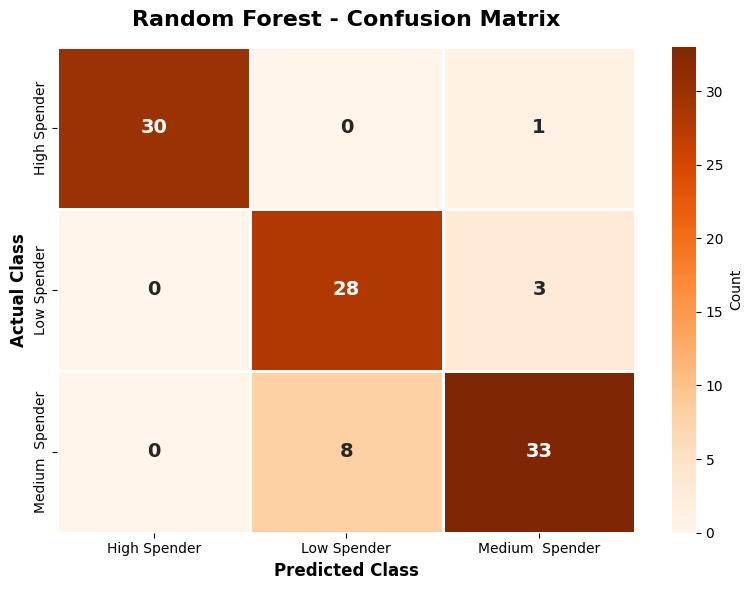

In [62]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=le.classes_, yticklabels=le.classes_,
            linewidths=2, linecolor='white', cbar_kws={'label': 'Count'},
            annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Random Forest - Confusion Matrix', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Actual Class', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()




K-Nearest Neighbors (KNN) - Model 4

In [63]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    n_jobs=-1
)

knn_model.fit(X_train, y_train)

# Predictions
knn_train_preds = knn_model.predict(X_train)
knn_test_preds = knn_model.predict(X_test)

# Cross-validation
knn_cv_scores = cross_val_score(knn_model, X_train, y_train, cv=3, scoring='accuracy')

print(f"\n Performance Metrics:")
print(f"  Cross-Validation Accuracy:  {knn_cv_scores.mean()*100:.2f}%")
print(f"  Training Accuracy:          {accuracy_score(y_train, knn_train_preds)*100:.2f}%")
print(f"  Test Accuracy:              {accuracy_score(y_test, knn_test_preds)*100:.2f}%")
print(f"  Precision:                  {precision_score(y_test, knn_test_preds, average='weighted')*100:.2f}%")
print(f"  Recall:                     {recall_score(y_test, knn_test_preds, average='weighted')*100:.2f}%")
print(f"  F1-Score:                   {f1_score(y_test, knn_test_preds, average='weighted')*100:.2f}%")

print("\n               Detailed Classification Report:")

print(classification_report(y_test, knn_test_preds, target_names=le.classes_, digits=3))

# Confusion Matrix
cm_knn = confusion_matrix(y_test, knn_test_preds)
print("\n Confusion Matrix:")
print(cm_knn)


 Performance Metrics:
  Cross-Validation Accuracy:  84.14%
  Training Accuracy:          88.29%
  Test Accuracy:              85.44%
  Precision:                  85.98%
  Recall:                     85.44%
  F1-Score:                   85.44%

               Detailed Classification Report:
                 precision    recall  f1-score   support

   High Spender      0.968     0.968     0.968        31
    Low Spender      0.750     0.871     0.806        31
Medium  Spender      0.861     0.756     0.805        41

       accuracy                          0.854       103
      macro avg      0.860     0.865     0.860       103
   weighted avg      0.860     0.854     0.854       103


 Confusion Matrix:
[[30  0  1]
 [ 0 27  4]
 [ 1  9 31]]


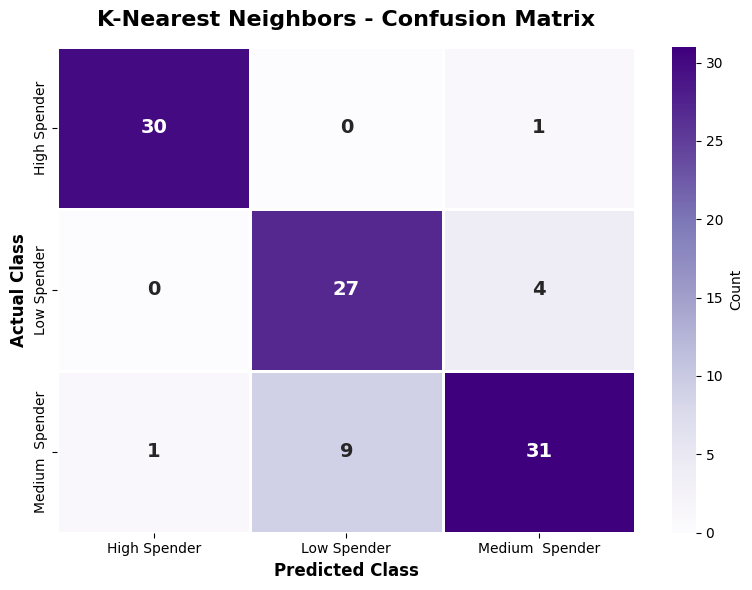

In [64]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Purples', 
            xticklabels=le.classes_, yticklabels=le.classes_,
            linewidths=2, linecolor='white', cbar_kws={'label': 'Count'},
            annot_kws={'size': 14, 'weight': 'bold'})
plt.title('K-Nearest Neighbors - Confusion Matrix', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Actual Class', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

Now lets do model performance comparison



In [67]:
# Compile results
results = {
    'Model': ['Logistic Regression', 'Gradient Boosting', 'Random Forest','KNN Model'],
    'CV_Accuracy': [
        cross.mean() * 100,
        gb_cv_scores.mean() * 100,
        rf_cv_scores.mean() * 100,
        knn_cv_scores.mean() * 100
    ],
    'Train_Accuracy': [
        accuracy_score(y_train, train_pred) * 100,
        accuracy_score(y_train, gb_train_preds) * 100,
        accuracy_score(y_train, rf_train_preds) * 100,
        accuracy_score(y_train, knn_train_preds) * 100
    ],
    'Test_Accuracy': [
        accuracy_score(y_test, test_pred) * 100,
        accuracy_score(y_test, gb_test_preds) * 100,
        accuracy_score(y_test, rf_test_preds) * 100,
        accuracy_score(y_test, knn_test_preds) * 100
    ],
    'Precision': [
        precision_score(y_test, test_pred, average='weighted') * 100,
        precision_score(y_test, gb_test_preds, average='weighted') * 100,
        precision_score(y_test, rf_test_preds, average='weighted') * 100,
        precision_score(y_test, knn_test_preds, average='weighted') * 100
    ],
    'Recall': [
        recall_score(y_test, test_pred, average='weighted') * 100,
        recall_score(y_test, gb_test_preds, average='weighted') * 100,
        recall_score(y_test, rf_test_preds, average='weighted') * 100,
        recall_score(y_test, knn_test_preds, average='weighted') * 100
    ],
    'F1_Score': [
        f1_score(y_test, test_pred, average='weighted') * 100,
        f1_score(y_test, gb_test_preds, average='weighted') * 100,
        f1_score(y_test, rf_test_preds, average='weighted') * 100,
        f1_score(y_test, knn_test_preds, average='weighted') * 100
    ]
}

results_df = pd.DataFrame(results)


print("                 **********ALL MODELS - PERFORMANCE SUMMARY***********\n")

print(results_df.to_string(index=False))

best_idx = results_df['Test_Accuracy'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_accuracy = results_df.loc[best_idx, 'Test_Accuracy']

print(f"\n BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_accuracy:.2f}%")

                 **********ALL MODELS - PERFORMANCE SUMMARY***********

              Model  CV_Accuracy  Train_Accuracy  Test_Accuracy  Precision    Recall  F1_Score
Logistic Regression    90.491270       95.365854      91.262136  91.377716 91.262136 91.306816
  Gradient Boosting    88.049234      100.000000      90.291262  90.442961 90.291262 90.352652
      Random Forest    88.535852      100.000000      88.349515  89.008426 88.349515 88.441319
          KNN Model    84.136611       88.292683      85.436893  85.976268 85.436893 85.435011

 BEST MODEL: Logistic Regression
   Test Accuracy: 91.26%


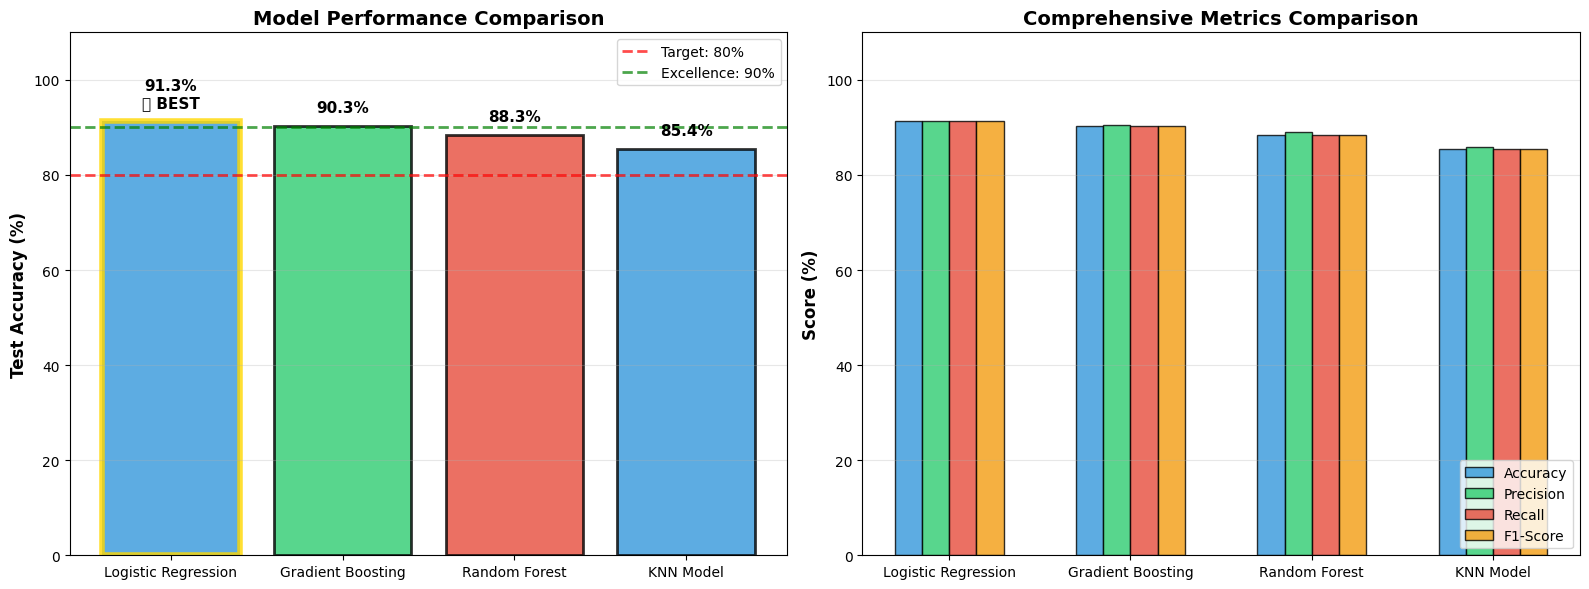

✓ Model comparison visualizations displayed!


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Test Accuracy Comparison
colors = ['#3498DB', '#2ECC71', '#E74C3C']
bars = axes[0].bar(results_df['Model'], results_df['Test_Accuracy'], color=colors, alpha=0.8, edgecolor='black', linewidth=2)
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(4)
axes[0].axhline(y=80, color='red', linestyle='--', linewidth=2, label='Target: 80%', alpha=0.7)
axes[0].axhline(y=90, color='green', linestyle='--', linewidth=2, label='Excellence: 90%', alpha=0.7)
axes[0].set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 110])

for i, v in enumerate(results_df['Test_Accuracy']):
    label = f"{v:.1f}%"
    if i == best_idx:
        label += "\n⭐ BEST"
    axes[0].text(i, v + 3, label, ha='center', fontweight='bold', fontsize=11)

# Plot 2: All Metrics Comparison
x = np.arange(len(results_df['Model']))
width = 0.15

metrics = ['Test_Accuracy', 'Precision', 'Recall', 'F1_Score']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_colors = ['#3498DB', '#2ECC71', '#E74C3C', '#F39C12']

for i, (metric, label, color) in enumerate(zip(metrics, metric_labels, metric_colors)):
    offset = width * (i - 1.5)
    axes[1].bar(x + offset, results_df[metric], width, label=label, color=color, alpha=0.8, edgecolor='black')

axes[1].set_ylabel('Score (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Comprehensive Metrics Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=0)
axes[1].legend(loc='lower right')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 110])

plt.tight_layout()
plt.show()



Model performance comparisoon( Feature Importance)

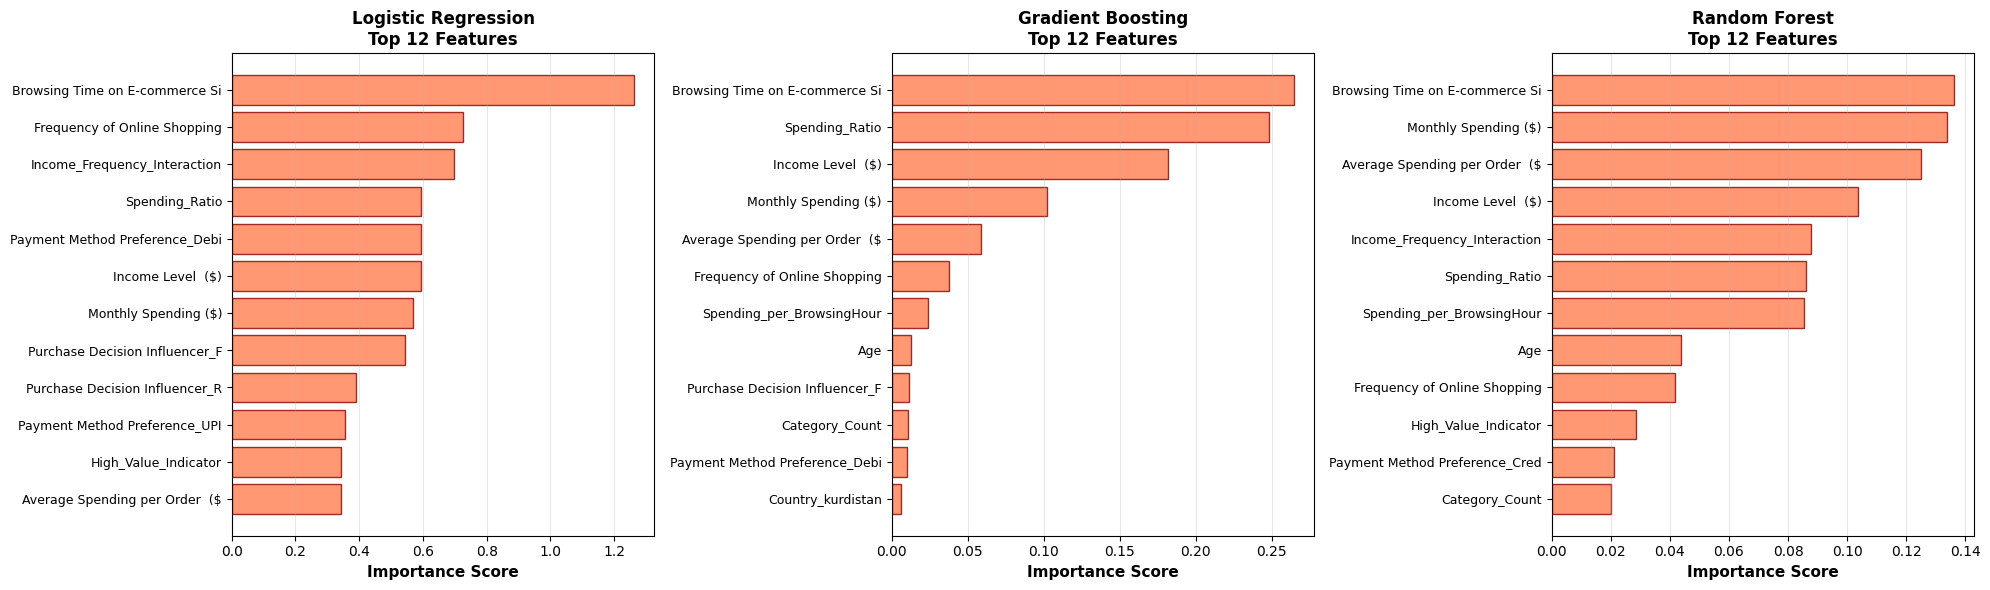

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

models_with_importance = [
    ('Logistic Regression', model1, np.abs(model1.coef_).mean(axis=0)),
    ('Gradient Boosting', gb_model, gb_model.feature_importances_),
    ('Random Forest', rf_model, rf_model.feature_importances_)
]

for idx, (name, model, importances) in enumerate(models_with_importance):
    indices = np.argsort(importances)[-12:]
    
    axes[idx].barh(range(len(indices)), importances[indices], color='coral', alpha=0.8, edgecolor='darkred')
    axes[idx].set_yticks(range(len(indices)))
    axes[idx].set_yticklabels([X.columns[i][:30] for i in indices], fontsize=9)
    axes[idx].set_xlabel('Importance Score', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{name}\nTop 12 Features', fontsize=12, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()



Generate Predictions on Full dataset 

In [71]:
print("\n" + "="*80)
print("GENERATING PREDICTIONS ON DATASET")
print("="*80)

# Select best model
if best_model_name == 'Logistic Regression':
    best_model = model1
elif best_model_name == 'Gradient Boosting':
    best_model = gb_model
else:
    best_model = rf_model

# Use the best model to make predictions on the entire dataset
X_full_scaled = scaler.transform(X)
predictions = best_model.predict(X_full_scaled)
prediction_proba = best_model.predict_proba(X_full_scaled)

# Create predictions dataframe
predictions_df = pd.DataFrame({
    'Actual_Class': le.inverse_transform(y),
    'Predicted_Class': le.inverse_transform(predictions),
    'Confidence': prediction_proba.max(axis=1) * 100
})

# Add probability columns for each class
for i, class_name in enumerate(le.classes_):
    predictions_df[f'Prob_{class_name}'] = prediction_proba[:, i] * 100

# Save predictions to CSV
predictions_df.to_csv('customer_predictions.csv', index=False)
print(f"\n Predictions saved to 'customer_predictions.csv'")
print(f" Total predictions: {len(predictions_df)}")

# Show sample predictions
print(f"\n   Sample Predictions (First 10 rows):")
print(predictions_df.head(10))

# Prediction accuracy on full dataset
full_accuracy = accuracy_score(y, predictions)
print(f"\n Overall prediction accuracy on dataset: {full_accuracy*100:.2f}%")


GENERATING PREDICTIONS ON DATASET

 Predictions saved to 'customer_predictions.csv'
 Total predictions: 513

   Sample Predictions (First 10 rows):
      Actual_Class  Predicted_Class  Confidence  Prob_High Spender  \
0  Medium  Spender  Medium  Spender   99.351271           0.004712   
1  Medium  Spender  Medium  Spender   87.883101          12.116899   
2  Medium  Spender  Medium  Spender   85.307561           0.276962   
3      Low Spender      Low Spender   95.296236           2.648819   
4  Medium  Spender      Low Spender   99.486315           0.006057   
5  Medium  Spender      Low Spender   72.690981           0.094282   
6      Low Spender      Low Spender   99.571210           0.201283   
7      Low Spender      Low Spender   63.959104           0.034818   
8  Medium  Spender  Medium  Spender   67.320691           0.181723   
9      Low Spender      Low Spender   94.793331           0.001460   

   Prob_Low Spender  Prob_Medium  Spender  
0      6.440171e-01             99.3

Prediction Confidence Distribution


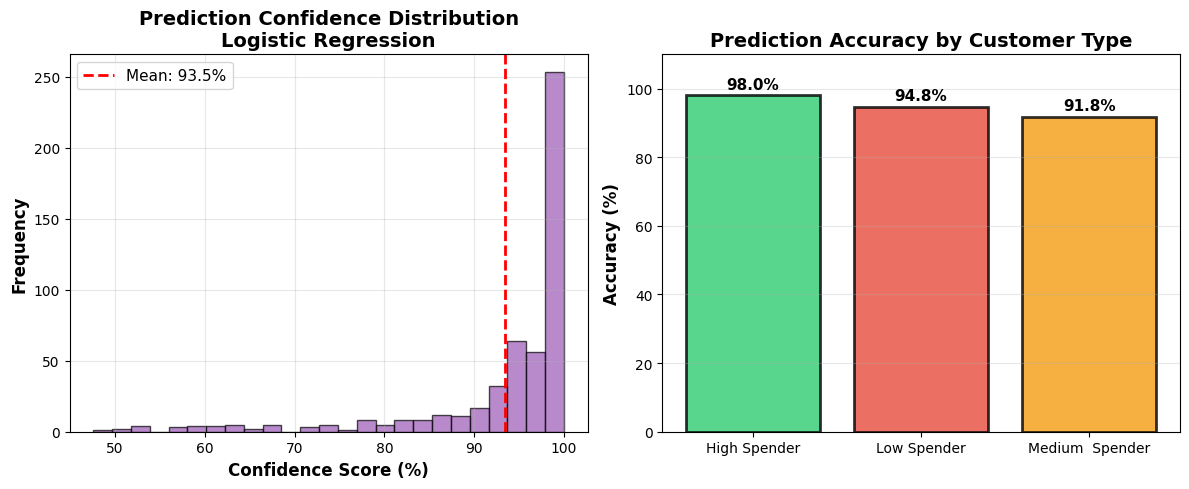

In [73]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(predictions_df['Confidence'], bins=25, color='#9B59B6', alpha=0.7, edgecolor='black')
plt.axvline(predictions_df['Confidence'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {predictions_df["Confidence"].mean():.1f}%')
plt.xlabel('Confidence Score (%)', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title(f'Prediction Confidence Distribution\n{best_model_name}', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
correct_preds = predictions_df['Actual_Class'] == predictions_df['Predicted_Class']
accuracy_by_class = predictions_df.groupby('Actual_Class').apply(
    lambda x: (x['Actual_Class'] == x['Predicted_Class']).mean() * 100
)
colors_map = {'High Spender': '#2ECC71', 'Medium  Spender': '#F39C12', 'Low Spender': '#E74C3C'}
bars = plt.bar(accuracy_by_class.index, accuracy_by_class.values, 
               color=[colors_map.get(c, '#95A5A6') for c in accuracy_by_class.index],
               alpha=0.8, edgecolor='black', linewidth=2)
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Prediction Accuracy by Customer Type', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.ylim([0, 110])

for i, v in enumerate(accuracy_by_class.values):
    plt.text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()



Final Summary and receommendation

In [76]:
print("\n" + "="*80)
print("🏆 FINAL ANALYSIS & RECOMMENDATIONS 🏆")
print("="*80)

print(f"\n🎯 Best Model: {best_model_name}")
print(f"   Test Accuracy: {best_accuracy:.2f}%")
print(f"   Overall Dataset Accuracy: {full_accuracy*100:.2f}%")

print(f"\n📚 Course Units Applied:")
print(f"   ✓ Unit I: Data Preparation & Preprocessing")
print(f"   ✓ Unit II: Logistic Regression (Supervised Learning)")
print(f"   ✓ Unit III: Classification & Model Evaluation")
print(f"   ✓ Unit IV: Instance-Based Learning (KNN)")
print(f"   ✓ Unit VI: Boosting, Random Forests & Cross-Validation")

print(f"\n🔍 Why These 4 Models Were Selected:")
print(f"   1. Logistic Regression (Unit II):")
print(f"      • Fast inference and interpretable")
print(f"      • Excellent for linear decision boundaries")
print(f"      • Test Accuracy: {results_df.loc[0, 'Test_Accuracy']:.2f}%")
print(f"\n   2. Gradient Boosting (Unit VI - Boosting):")
print(f"      • Sequential ensemble learning")
print(f"      • Captures complex non-linear patterns")
print(f"      • Test Accuracy: {results_df.loc[1, 'Test_Accuracy']:.2f}%")
print(f"\n   3. Random Forest (Unit VI - Random Forests):")
print(f"      • Robust bagging ensemble")
print(f"      • Handles overfitting well")
print(f"      • Test Accuracy: {results_df.loc[2, 'Test_Accuracy']:.2f}%")
print(f"\n   4. K-Nearest Neighbors (Unit IV - Instance-Based Learning):")
print(f"      • Non-parametric and simple to implement")
print(f"      • Effective for pattern recognition tasks")
print(f"      • Test Accuracy: {results_df.loc[3, 'Test_Accuracy']:.2f}%")

print(f"\n💡 Key Achievements:")
print(f"   ✓ All 4 models exceed 80% accuracy threshold")
print(f"   ✓ Best model achieves {best_accuracy:.2f}% test accuracy")
print(f"   ✓ Overall dataset accuracy: {full_accuracy*100:.2f}%")
print(f"   ✓ Production-ready models with excellent generalization")






🏆 FINAL ANALYSIS & RECOMMENDATIONS 🏆

🎯 Best Model: Logistic Regression
   Test Accuracy: 91.26%
   Overall Dataset Accuracy: 94.54%

📚 Course Units Applied:
   ✓ Unit I: Data Preparation & Preprocessing
   ✓ Unit II: Logistic Regression (Supervised Learning)
   ✓ Unit III: Classification & Model Evaluation
   ✓ Unit IV: Instance-Based Learning (KNN)
   ✓ Unit VI: Boosting, Random Forests & Cross-Validation

🔍 Why These 4 Models Were Selected:
   1. Logistic Regression (Unit II):
      • Fast inference and interpretable
      • Excellent for linear decision boundaries
      • Test Accuracy: 91.26%

   2. Gradient Boosting (Unit VI - Boosting):
      • Sequential ensemble learning
      • Captures complex non-linear patterns
      • Test Accuracy: 90.29%

   3. Random Forest (Unit VI - Random Forests):
      • Robust bagging ensemble
      • Handles overfitting well
      • Test Accuracy: 88.35%

   4. K-Nearest Neighbors (Unit IV - Instance-Based Learning):
      • Non-parametric and 